In [22]:
import pandas as pd
import warnings
import json
import numpy as np
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import pymongo
from pymongo import MongoClient
import pickle

%matplotlib inline

In [2]:
def get_database():
    
    CONNECTION_STRING = "mongodb+srv://admin:<password>@<cluster>"
    client = MongoClient(CONNECTION_STRING)
    return client['oct30']

def load_df_from_mongo(collectionName):
    mongo_db = get_database()
    collection = mongo_db[collectionName] 
    cursor = collection.find({})
    df =  pd.DataFrame(list(cursor))
    del df['_id']
    return df

## Model building

### Logitic classifier

In [3]:
data_model = load_df_from_mongo('classifier')
data_model_copy = data_model.copy()

In [4]:
X = data_model_copy.drop('salary_target',axis=1)
y = data_model_copy['salary_target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

print("Train: ",X_train.shape, y_train.shape)
print("Test: ",X_test.shape, y_test.shape)

Train:  (22792, 10) (22792,)
Test:  (9769, 10) (9769,)


In [6]:
preprocessor = ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), X_train.select_dtypes(['int','float']).columns),
                    ("cat", OneHotEncoder(handle_unknown="ignore"),
                     X_train.select_dtypes('object').columns),
                ])
clf = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_trans = clf.fit_transform(X_train)

trans_col = clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
trans_col = list(X_train.select_dtypes(['int','float']).columns) + list(trans_col)

X_train_trans = pd.DataFrame.sparse.from_spmatrix(X_train_trans,
                                                     columns=list(trans_col))

X_test_trans = clf.transform(X_test)
X_test_trans = pd.DataFrame.sparse.from_spmatrix(X_test_trans,
                                                     columns=list(trans_col))

In [7]:
log_classifier=LogisticRegression()
log_classifier.fit(X_train_trans, y_train)
ytrain_pred = log_classifier.predict_proba(X_train_trans)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = log_classifier.predict_proba(X_test_trans)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic train roc-auc: 0.899133909720813
Logistic test roc-auc: 0.89527247031599


### Support vector classifier

In [8]:
data_model_copy = data_model.copy()

X = data_model_copy.drop('salary_target',axis=1)
y = data_model_copy['salary_target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

print("Train: ",X_train.shape, y_train.shape)
print("Test: ",X_test.shape, y_test.shape)

Train:  (22792, 10) (22792,)
Test:  (9769, 10) (9769,)


In [9]:
preprocessor = ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), X_train.select_dtypes(['int','float']).columns),
                    ("cat", OneHotEncoder(handle_unknown="ignore"),
                     X_train.select_dtypes('object').columns),
                ])
clf = Pipeline(steps=[('preprocessor', preprocessor),('model',SVC(probability=True))])



In [10]:
# You can go ahead and try to add addition value and try in different kernels
param_grid = {'model__C': [0.1], 
              'model__gamma': [0.1],
              'model__kernel': ['rbf']} 
# we can add multiple paramter like different kernels and play with gamma value

In [11]:
grid = GridSearchCV(clf, param_grid, verbose = 3,refit=True)

In [12]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__C=0.1, model__gamma=0.1, model__kernel=rbf;, score=0.848 total time= 2.5min
[CV 2/5] END model__C=0.1, model__gamma=0.1, model__kernel=rbf;, score=0.847 total time= 3.1min
[CV 3/5] END model__C=0.1, model__gamma=0.1, model__kernel=rbf;, score=0.846 total time= 2.8min
[CV 4/5] END model__C=0.1, model__gamma=0.1, model__kernel=rbf;, score=0.851 total time= 2.9min
[CV 5/5] END model__C=0.1, model__gamma=0.1, model__kernel=rbf;, score=0.846 total time= 4.1min


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'education-num', 'sex', 'hours-per-week', 'capital.income',
       'is_married', 'husband_or_wife'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['workclass', 'occupation', 'race'], dtype='object'))])),
                                       ('model', SVC(probability=True))]),
             param_grid={'model__C': [0.1], 'model__gamma': [0.1],
                         'model__kernel': ['rbf']},
             verbose=3)

In [13]:
ytrain_pred_sv = grid.predict_proba(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred_sv = grid.predict_proba(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic train roc-auc: 0.899133909720813
Logistic test roc-auc: 0.89527247031599


## roc curve for logisitc classification and support vector classifier

### logistic regression

In [14]:
pred=[]
for model in [log_classifier]:
    pred.append(pd.Series(model.predict_proba(X_test_trans)[:,1]))
final_prediction_log=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction_log)))

Ensemble test roc-auc: 0.89527247031599


In [24]:
fpr, tpr, thresholds = roc_curve(y_test, final_prediction_log)
thresholds

array([2.00000000e+00, 1.00000000e+00, 9.85024677e-01, ...,
       1.37451184e-03, 1.36103473e-03, 3.02879788e-04])

In [16]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction_log>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
645,0.544673,0.849217
653,0.542377,0.849217
651,0.542765,0.849217
650,0.542937,0.849217
649,0.543320,0.849217


In [17]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

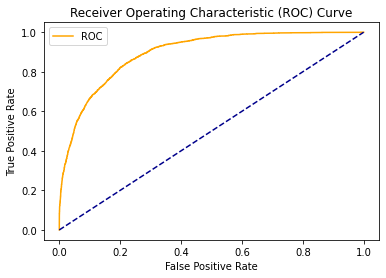

In [25]:
plot_roc_curve(fpr,tpr)

### Support vector classifier

In [18]:
pred=[]
for model in [grid]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
final_prediction_sv=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction_sv)))

Ensemble test roc-auc: 0.88369119934241


In [19]:
fpr, tpr, thresholds = roc_curve(y_test, final_prediction_log)
thresholds

array([2.00000000e+00, 1.00000000e+00, 9.85024677e-01, ...,
       1.37451184e-03, 1.36103473e-03, 3.02879788e-04])

In [20]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction_sv>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
1120,0.351548,0.854438
1119,0.352703,0.854438
1121,0.351412,0.854438
1117,0.353160,0.854335
1118,0.353064,0.854335


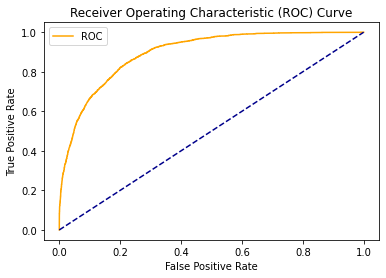

In [23]:
plot_roc_curve(fpr,tpr)

### pickling the model for later use

In [27]:
pickle.dump(log_classifier, open('logistic_classifier.pkl', 'wb'))
pickle.dump(grid, open('support_vector_classifier.pkl', 'wb'))